## Introduction

Netflix is an American, subscription-based service offering online streaming from a library of films and television series, including those produced in-house. Similar to Netflix, Disney Plus service distributes films and television series produced by The Walt Disney Studios and Walt Disney Television and is one of the biggest competitor of Netflix. 

Due to Covid, there has been a tremendous increase in usage of OTT platform as cinemas were shut down and more people were staying home.

## Problem Statement

As more people are shifting towards OTT platform, we would like to get more insights in the similarities and differences between two of the most competitive online streaming platforms - Netflix and Disneyplus. This analysis would help understand users which platform is more suitable for them and hence which one they would like to choose.

**This notebook contains the cleaning, preprocessing and exploratory analysis of netflix and disney plus posts scraped in previous notebooks.**


### Contents

- [Netflix](#Netflix)
    - [Import Netflix Posts](#Import-Netflix-Posts)
    - [Netflix Data Cleaning](#Netflix-Data-Cleaning)
- [Disney Plus](#Disney-Plus)
    - [Import DisneyPlus Posts](#Import-DisneyPlus-Posts)
    - [DisneyPlus Data Cleaning](#DisneyPlus-Data-Cleaning)
- [Data Preprocessing](#Data-Preprocessing)
- [Export Cleaned & Preprocessed Data](#Export-Cleaned-and-Preprocessed-Data)
- [Exploratory Analysis](#Exploratory-Analysis)

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer

## Netflix

### Import Netflix Posts

In [4]:
netflix = pd.read_csv('../Data/Netflix.csv')

In [5]:
netflix.shape

(1467, 108)

In [6]:
netflix.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,media_metadata,is_gallery,gallery_data,link_flair_template_id,author_cakeday
0,NaN,netflix,NaN,t2_6yobi,False,NaN,0,False,Netflix now allows you to remove a movie/serie...,[],...,805717,1.594813e+09,1,{'oembed': {'provider_url': 'http://imgur.com'...,False,NaN,NaN,NaN,NaN,NaN
1,NaN,netflix,"Hello everyone, 8 years ago we woke up one day...",t2_3cpw5xub,False,NaN,2,False,"Hi we're Mark, Zach and Broden from Aunty Donn...",[],...,805717,1.605562e+09,4,NaN,False,NaN,NaN,NaN,NaN,NaN
2,NaN,netflix,NaN,t2_z3vs,False,NaN,0,False,STUDY: Majority of U.S. Parents Feel Guilty Ab...,[],...,805717,1.615308e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
3,NaN,netflix,NaN,t2_6byhg3ps,False,NaN,0,False,Looks like someone is trying to use Netflix as...,[],...,805717,1.615342e+09,0,"{'reddit_video': {'bitrate_kbps': 2400, 'fallb...",True,NaN,NaN,NaN,NaN,NaN
4,NaN,netflix,NaN,t2_9djc3jwm,False,NaN,0,False,Ozark season 4: Agent Maya Miller star shares ...,[],...,805717,1.615325e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN


### Netflix Data Cleaning

#### Check Null Values

In [7]:
netflix[['selftext', 'title']].isnull().sum()

selftext    361
title         0
dtype: int64

If the selftext is null, it means that the post have either a link, image or video. 

However, we will keep all these posts as they will have some text in their title which might be useful when classifying. Hence we will fill all the null posts with empty text.

In [8]:
netflix.fillna('', inplace = True)

#### Concat Fields

Next we will combine the selft text and title, as at the end we just want bag of words from an individual post.

In [9]:
netflix['selftext/title'] = netflix['selftext'] + ' ' + netflix['title']

#### Remove Duplicates

While scrapping from reddit to fetch the netflix posts, we might have received multiple duplicate posts. Hence to avoid redundancy, we will remove all the duplicate posts with respect to the combined self text and the title.

In [10]:
netflix.drop_duplicates(subset=['selftext/title'], keep='first', inplace = True)

In [11]:
netflix.shape

(607, 109)

After cleaning the data we are left with 607 posts from Netflix, which means that 860 posts were dropped as they were duplicates from scraping. But this would be good enough to proceed with our analysis and classification as we do have enough text from the posts. 

However we do need to keep in mind the number of posts we get from Disney plus after cleaning as the data should not be too biased.

For classification purpose we only need the text fields, so we will keep the original and the combined text fields and drop the rest.

In [12]:
netflix = netflix[['selftext', 'title', 'selftext/title', 'subreddit']]
netflix.shape

(607, 4)

## Disney Plus

### Import Disney Plus Posts

In [13]:
disneyplus = pd.read_csv('../Data/DisneyPlus.csv')

In [14]:
disneyplus.shape

(1491, 115)

In [15]:
disneyplus.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,media,is_video,url_overridden_by_dest,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,collections,author_cakeday
0,NaN,DisneyPlus,[Join the Cordcutting &amp; Streaming TV Disco...,t2_6l4z3,False,NaN,0,False,Join the Cordcutting &amp; Streaming TV Discord,"[{'e': 'text', 't': 'Announcement'}]",...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,DisneyPlus,NaN,t2_8wpjm,False,NaN,0,False,End credit of Raya &amp; the last dragon 😂,"[{'a': ':WORLD:', 'e': 'emoji', 'u': 'https://...",...,NaN,False,https://i.redd.it/7aqr5wp7i4m61.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,DisneyPlus,NaN,t2_x2ai7,False,NaN,0,False,Disney+ Passes 100 Million Paid Subscribers,"[{'a': ':WORLD:', 'e': 'emoji', 'u': 'https://...",...,NaN,False,https://www.hollywoodreporter.com/news/disney-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,DisneyPlus,NaN,t2_rgsvw,False,NaN,0,False,Where We Are in the Riordanverse! | Rick Riord...,[],...,NaN,False,https://rickriordan.com/2021/03/where-we-are-i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,DisneyPlus,NaN,t2_rgsvw,False,NaN,0,False,‘WandaVision’ EP Jac Schaeffer On Who Didn’t S...,[],...,NaN,False,https://deadline.com/2021/03/wandavision-serie...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DisneyPlus Data Cleaning

#### Check Null Values

In [16]:
disneyplus[['selftext', 'title']].isnull().sum()

selftext    615
title         0
dtype: int64

Similar to netflix, if selftext is null, it means that the post have either a link, image or video. 

However, we will keep all these posts as they will have some text in their title which might be useful when classifying. Hence we will fill all the null posts with empty text.

In [17]:
disneyplus.fillna(' ', inplace = True)

#### Concat Fields

Next we will combine the selft text and title as at the end we just want bag of words from an individual post.

In [18]:
disneyplus['selftext/title'] = disneyplus['selftext'] + ' ' + disneyplus['title']

#### Remove Duplicates

While scrapping from reddit to fetch the disney plus posts, we might have received multiple duplicated posts. Hence to avoid redundancy, we will remove all the duplicate posts with respect to the combined self text and the title.

In [19]:
disneyplus.drop_duplicates(subset=['selftext/title'], keep = 'first', inplace = True)

In [20]:
disneyplus.shape

(669, 116)

At the end we are left with 669 posts from Disney Plus which means 822 posts were duplicates. 

Now if we compare the number of posts of Netflix(607 posts) and Disney plus(669 posts) we can say that the data is not too biased to any one subreddit. Hence it would be appropriate to carry the analysis and subreddit classification.

As we only need the text fields, we will keep the original and the combined text fields and drop the rest.

In [21]:
disneyplus = disneyplus[['selftext', 'title', 'selftext/title', 'subreddit']]
disneyplus.shape

(669, 4)

## Data Preprocessing

After cleaning the data we have self text and title fields combined for each subreddit. However we still need to preprocess the text for further analysis.

The text now is in form of full sentences which will include all conjuctions, prepositions, etc. We now need to convert the text into more digestable form which is understandable by machine learning algorithms. This process includes removing html tags, removing stop words like "and, in, or " and convert all words to its root form(eg studying to study). 


### Declaring Stopwords

In [22]:
stopwords = set(stopwords.words('english'))

In addition to the default english stopwords, we will also remove few more like netflix and disney plus which might be biased when predicting the posts.

In [23]:
additional_stopwords = {'netflix', 'disney', 'disneyplus', 'disney+','www', 'http', 'https', 'com', 'reddit', 'subreddit'}

In [24]:
all_stopwords = stopwords.union(additional_stopwords)

In [25]:
print("All stopwords :",len(all_stopwords))

All stopwords : 189


In [26]:
def preprocess_raw_text(raw_text):
    '''
    Function to convert raw text to a string of words.
    Split string into words, Remove stopwords, Lemmetize the words
    '''
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. Remove stopwords.
    meaningful_words = [w for w in words if not w in all_stopwords]
    
    #4. Lemmetize the words.
    lemmatizer = PorterStemmer()
    lemmas = [lemmatizer.stem(mw) for mw in meaningful_words]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lemmas))

### Preprocess Netflix Data

In [27]:
netflix_cleaned_text = [preprocess_raw_text(i) for i in netflix['selftext/title']]

In [28]:
netflix_cleaned_text[:5]

['allow remov movi seri continu watch row',
 'hello everyon year ago woke one day found one youtub video gone crazi r video year later thank lot support form commun got shot tv show aunti donna big ol hous fun gonna answer anyth next hour answer today aforement three perform well head writer sam lingham film maker max miller compos tom armstrong know littl introductori playlist work far youtub playlist list plezn zmgptsc jzquvg xrdfonsmaq proof redd ryyg p amhz jpg redd fwqcmhz jpg redd dn dpwemhz jpg edit okay bro mark zach gotta sign bit go record pod bt boy might stick around littl bit pl keep ask etc tri jump back answer next day thank wonder question support hope enjoy enjoy show hi mark zach broden aunti donna got first big break releas first tv seri ama',
 'studi major u parent feel guilti kid screen time',
 'look like someon tri use platform send weird messag young royal life joke open eye noth special new amp limit inform display comedi drama mysteri differ countri',
 'ozark s

We can see from the cleaned sample data above that the text has been processed and converted to words which are more compatible with machine learning algorithm

In [29]:
netflix['cleaned_text'] = netflix_cleaned_text

In [30]:
netflix = netflix[['selftext/title', 'cleaned_text', 'subreddit']]

In [31]:
netflix.head()

,selftext/title,cleaned_text,subreddit
0,Netflix now allows you to remove a movie/seri...,allow remov movi seri continu watch row,netflix
1,"Hello everyone, 8 years ago we woke up one day...",hello everyon year ago woke one day found one ...,netflix
2,STUDY: Majority of U.S. Parents Feel Guilty A...,studi major u parent feel guilti kid screen time,netflix
3,Looks like someone is trying to use Netflix a...,look like someon tri use platform send weird m...,netflix
4,Ozark season 4: Agent Maya Miller star shares...,ozark season agent maya miller star share firs...,netflix


### Preprocess DisneyPlus Data

In [32]:
disneyplus_clean_text = [preprocess_raw_text(i) for i in disneyplus['selftext/title']]

In [33]:
disneyplus_clean_text[:5]

['join cordcut amp stream tv discord discord gg rjxx cw eg discord server recent expand includ channel stream servic includ hulu paramount gain access channel use role selector channel expans also invit new name cordcut amp stream tv start discord server august launch sinc time seen server expand nearli individu great convers servic includ troubleshoot content like mandalorian wandavis discord merger current server run partner subreddit realiz us subscrib multipl stream servic discord dedic streamer fragment fandom expans creat unit commun talk fan mandalorian picard bridgerton alik gain access channel relev use role selector channel discord pick channel relev avoid other hope expans enrich convers begin discuss streamer like hulu paramount use follow link discord gg rjxx cw eg discord gg rjxx cw eg happi watch join cordcut amp stream tv discord',
 'end credit raya amp last dragon',
 'pass million paid subscrib',
 'riordanvers rick riordan updat perci jackson seri',
 'wandavis ep jac s

In [34]:
disneyplus['cleaned_text'] = disneyplus_clean_text

In [35]:
disneyplus = disneyplus[['selftext/title', 'cleaned_text', 'subreddit']]

In [36]:
disneyplus.head()

,selftext/title,cleaned_text,subreddit
0,[Join the Cordcutting &amp; Streaming TV Disco...,join cordcut amp stream tv discord discord gg ...,DisneyPlus
1,End credit of Raya &amp; the last dragon 😂,end credit raya amp last dragon,DisneyPlus
2,Disney+ Passes 100 Million Paid Subscribers,pass million paid subscrib,DisneyPlus
3,Where We Are in the Riordanverse! | Rick Rio...,riordanvers rick riordan updat perci jackson seri,DisneyPlus
4,‘WandaVision’ EP Jac Schaeffer On Who Didn’t...,wandavis ep jac schaeffer show amp seri final,DisneyPlus


### Combine the Netflix and DisneyPlus data

For further analysis/classification we will combine the posts from Netflix and DisneyPlus

In [37]:
netflix_disneyplus = pd.concat([netflix, disneyplus])

In [38]:
netflix_disneyplus.shape

(1276, 3)

In [39]:
netflix_disneyplus.head()

,selftext/title,cleaned_text,subreddit
0,Netflix now allows you to remove a movie/seri...,allow remov movi seri continu watch row,netflix
1,"Hello everyone, 8 years ago we woke up one day...",hello everyon year ago woke one day found one ...,netflix
2,STUDY: Majority of U.S. Parents Feel Guilty A...,studi major u parent feel guilti kid screen time,netflix
3,Looks like someone is trying to use Netflix a...,look like someon tri use platform send weird m...,netflix
4,Ozark season 4: Agent Maya Miller star shares...,ozark season agent maya miller star share firs...,netflix


In [40]:
netflix_disneyplus.tail()

,selftext/title,cleaned_text,subreddit
665,New Trailer for Disney+Star,new trailer star,DisneyPlus
666,Raya and The Last Dragon available to all su...,raya last dragon avail subscrib june th,DisneyPlus
667,my 2 year old is constantly sending text messa...,year old constantli send text messag peopl eve...,DisneyPlus
668,Marvel's 'Blade' Movie Finds Its Writer in '...,marvel blade movi find writer watchmen scribe ...,DisneyPlus
669,New Wanda and Vision profile icons have been...,new wanda vision profil icon ad plu,DisneyPlus


In order to classify the subreddits, we will map the subreddit column to a numeric representation.

Netflix : 0 <br>
DisneyPlus : 1

In [41]:
netflix_disneyplus['subreddit'] = netflix_disneyplus['subreddit'].map({'netflix': 0, 'DisneyPlus': 1})

In [42]:
netflix_disneyplus['subreddit'].value_counts()

1    669
0    607
Name: subreddit, dtype: int64

### Export Cleaned & Preprocessed Data

In [43]:
netflix_disneyplus.to_csv('../Data/Netflix_DisneyPlus_Cleaned.csv', index=False)

## Exploratory Analysis 

We will now analyse the text from these subreddits and get better understanding of the words/topics discussed in each subreddit. To do that we will use countvectorizer to count all the words or features.

In [44]:
cvec = CountVectorizer(stop_words=all_stopwords)

### Plot Functions

Used later for plotting graphs

In [45]:
def plot_wordcloud(text_series, background, color):
    '''
    Plot the word cloud.
    '''
    cloud_text = ' '
    
    # Split text to words
    for i in text_series:
        cloud_text = cloud_text + ' ' + i
    
    wordcloud = WordCloud(height=800, 
                          width=1800, 
                          margin=0, 
                          background_color=background, 
                          colormap=color).generate(cloud_text)
    plt.figure(figsize=(26, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

In [46]:
def plot_stembar(df, title):
    '''
    Plot stem chart(version of bar plot) 
    '''
    my_range=range(0,len(df.index))

    plt.figure(figsize=(10,6))
    plt.stem(df['word_count'])
    plt.xticks(my_range, df.index, rotation='vertical')
    plt.ylabel('Word Count')
    plt.title(title);

### Netflix EDA

In [47]:
netflix_cvec = cvec.fit_transform(netflix['cleaned_text'])

Fetch all features/words for the Netflix subreddit

In [48]:
netflix_features = cvec.get_feature_names() 
netflix_features

['aang',
 'ab',
 'abandon',
 'abbca',
 'abduct',
 'abid',
 'abil',
 'abit',
 'abl',
 'abruptli',
 'absolut',
 'abus',
 'academ',
 'academi',
 'accent',
 'accept',
 'access',
 'accid',
 'accident',
 'accomplic',
 'accomplish',
 'accord',
 'account',
 'accross',
 'accur',
 'accuraci',
 'accus',
 'accusam',
 'acdemi',
 'achiev',
 'acquir',
 'across',
 'act',
 'action',
 'activ',
 'actor',
 'actress',
 'actual',
 'ad',
 'adapt',
 'add',
 'addam',
 'addict',
 'addit',
 'address',
 'ade',
 'adel',
 'adelstein',
 'adject',
 'adjust',
 'admin',
 'admir',
 'admiss',
 'admit',
 'admittedli',
 'adolesc',
 'ador',
 'adress',
 'adrian',
 'adult',
 'advanc',
 'advantag',
 'adventur',
 'advers',
 'advertis',
 'advic',
 'ae',
 'aesthet',
 'affect',
 'affili',
 'afflict',
 'afford',
 'aforement',
 'afraid',
 'aftermath',
 'age',
 'agent',
 'ago',
 'agre',
 'ahead',
 'ahrenberg',
 'air',
 'airbend',
 'airpod',
 'aka',
 'al',
 'ala',
 'alarm',
 'alcohol',
 'alec',
 'alert',
 'alex',
 'alexand',
 'alexand

In [49]:
print('No of features for Netflix:', len(netflix_features))

No of features for Netflix: 4391


In [50]:
netflix_cvec_df = pd.DataFrame(netflix_cvec.toarray(), columns=cvec.get_feature_names())

In [51]:
netflix_cvec_df.head()

,aang,ab,abandon,abbca,abduct,abid,abil,abit,abl,abruptli,...,zealand,zendaya,zero,zine,zmgptsc,zoe,zombeav,zombi,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
netflix_wordcount = netflix_cvec_df.sum(axis=0).sort_values(ascending=False).to_frame('word_count')
netflix_wordcount

,word_count
watch,413
show,403
like,291
movi,245
seri,176
...,...
marcu,1
manipul,1
maneuv,1
mandolorian,1


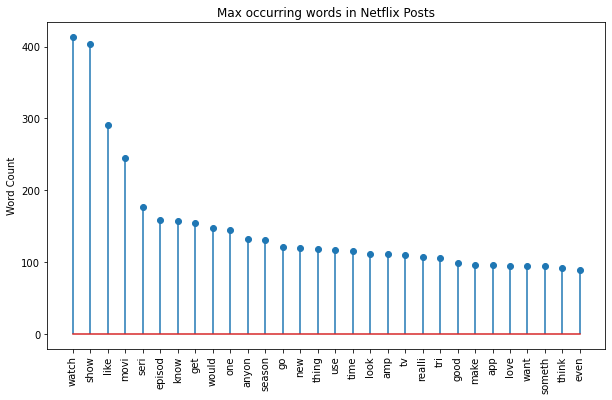

In [53]:
plot_stembar(netflix_wordcount.head(30), 'Max occurring words in Netflix Posts')

Above are the top 30 maximum occurring words for Netflix. We can see that there are several general words like watch, show, new, episode, season, etc which are listed among the most occurring words. <br>
This means that people in the posts are mainly talking about new/old episodes or even a season of the show. <br>
Let us visually make it clear through a word cloud.

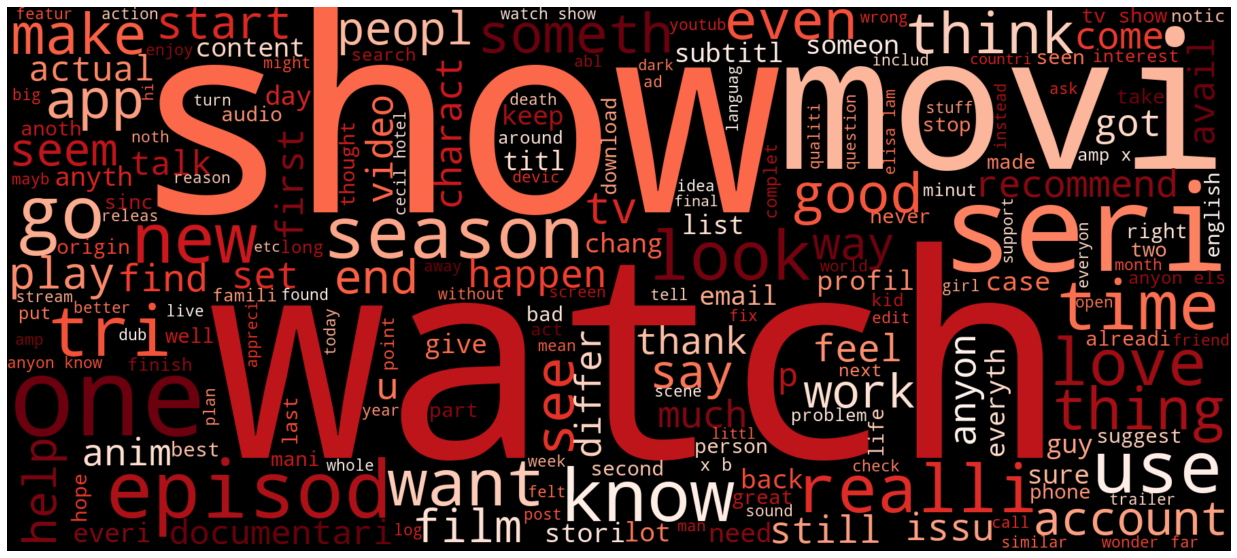

In [54]:
plot_wordcloud(netflix['cleaned_text'], 'black', 'Reds')

One thing that has been noticed from the above word cloud is that there is not much emphasis on any of a specific tv show or movie. However interestingly we can see that netflix also contains documentary and anime movies.

### DisneyPlus EDA

In [55]:
disneyplus_cvec = cvec.fit_transform(disneyplus['cleaned_text'])

Fetch all features/words for the Disney Plus subreddit

In [56]:
disneyplus_features = cvec.get_feature_names()
disneyplus_features

['ab',
 'abba',
 'abc',
 'abe',
 'abeltj',
 'abil',
 'abl',
 'abort',
 'abou',
 'absolut',
 'absorb',
 'accent',
 'accept',
 'access',
 'accid',
 'accident',
 'acclaim',
 'accompani',
 'accord',
 'account',
 'accumul',
 'acer',
 'achiev',
 'acorn',
 'acquir',
 'acquisit',
 'across',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'ad',
 'adapt',
 'adaptor',
 'adblock',
 'add',
 'addit',
 'addon',
 'address',
 'adel',
 'adher',
 'adjust',
 'adult',
 'advanc',
 'adventur',
 'advertis',
 'advic',
 'aeroplan',
 'af',
 'afc',
 'affect',
 'afford',
 'afterward',
 'afv',
 'age',
 'agent',
 'ago',
 'agre',
 'agreement',
 'ahead',
 'ahukewia',
 'air',
 'ak',
 'aka',
 'al',
 'ala',
 'aladdin',
 'alan',
 'album',
 'alcatraz',
 'alcohol',
 'alderan',
 'alexa',
 'algorithm',
 'alien',
 'alik',
 'allen',
 'allow',
 'almost',
 'alon',
 'along',
 'alphabet',
 'alreadi',
 'also',
 'altern',
 'although',
 'altogeth',
 'alway',
 'amaz',
 'amazon',
 'amelia',
 'america',
 'american',
 'among',
 'amount

In [57]:
print("No of features for Disney Plus",len(disneyplus_features))

No of features for Disney Plus 3054


In [58]:
disneyplus_cvec_df = pd.DataFrame(disneyplus_cvec.toarray(), columns=cvec.get_feature_names())

In [59]:
disneyplus_cvec_df.head()

,ab,abba,abc,abe,abeltj,abil,abl,abort,abou,absolut,...,zodiac,zoe,zombi,zone,zooey,zoom,zootopia,zuster,zwwz,zysq
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
disneyplus_wordcount = disneyplus_cvec_df.sum(axis=0).sort_values(ascending=False).to_frame('word_count')
disneyplus_wordcount

,word_count
watch,244
show,238
episod,202
star,200
plu,179
...,...
makeup,1
makia,1
malta,1
maman,1


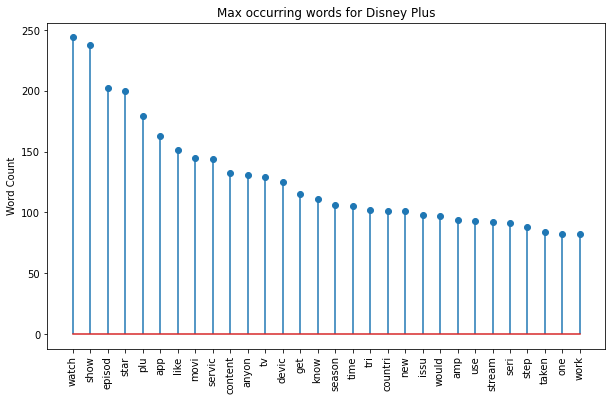

In [61]:
plot_stembar(disneyplus_wordcount.head(30), 'Max occurring words for Disney Plus')

Above are the top 30 maximum occurring words for Disney Plus. We can see that similar to netflix there are several generalized words like watch, show, episode, new, and some additional words like star, plu, content, countri, etc. <br>
Here also we can say that people are talking about the several shows and its content which they are watching, suggesting or recommending. <br>
Let us visualize the word count through word cloud. 

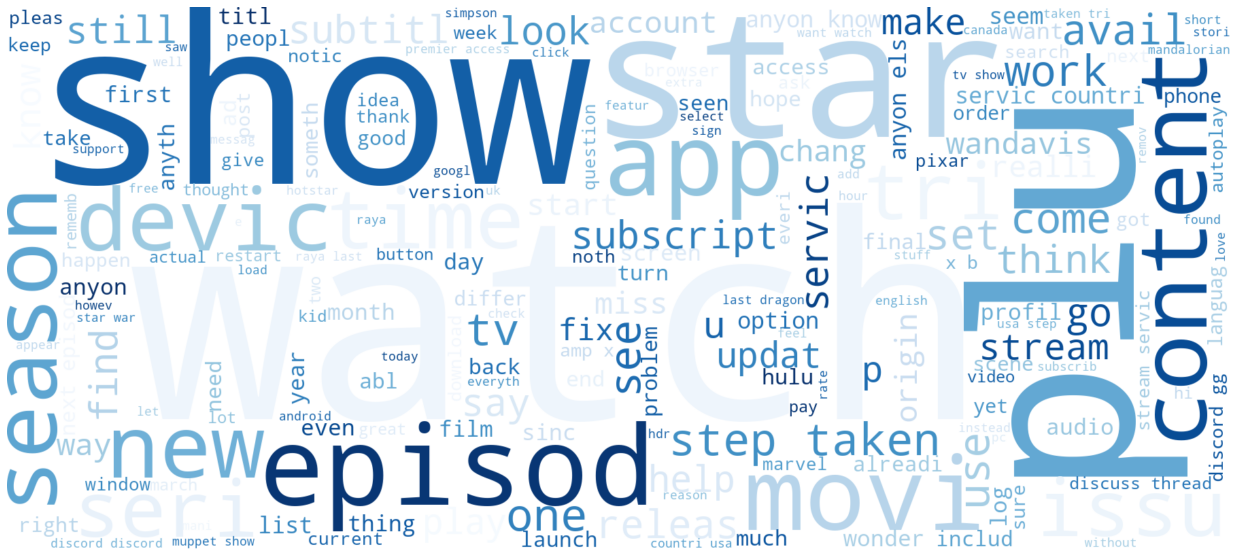

In [62]:
plot_wordcloud(disneyplus['cleaned_text'], 'white', 'Blues')

Contrary to Netflix, we can see from the above word cloud that there are few movies/series that are highlighted in above word cloud like simpsons, raya, wandavis.

### Netflix + DisneyPlus EDA

We now would analyse the common words between the subreddits

In [63]:
common_words = set(netflix_features).intersection(disneyplus_features)

In [64]:
print("No of common features: ",len(common_words))

No of common features:  1837


In [65]:
common_words

{'kevin',
 'boy',
 'okay',
 'sister',
 'tomorrow',
 'prefer',
 'known',
 'juli',
 'background',
 'better',
 'tediou',
 'goe',
 'inc',
 'matter',
 'ms',
 'sit',
 'normal',
 'compar',
 'unabl',
 'still',
 'docu',
 'cap',
 'creat',
 'gt',
 'bar',
 'fast',
 'deserv',
 'back',
 'costum',
 'safe',
 'plu',
 'technolog',
 'give',
 'possibl',
 'configur',
 'today',
 'letter',
 'parti',
 'rewatch',
 'simpli',
 'exit',
 'journey',
 'kinda',
 'whenev',
 'kingdom',
 'spoil',
 'cellphon',
 'keyboard',
 'place',
 'threaten',
 'ye',
 'tri',
 'silli',
 'furthermor',
 'baffl',
 'angel',
 'drop',
 'particularli',
 'cute',
 'present',
 'button',
 'term',
 'weekend',
 'much',
 'explor',
 'bright',
 'knew',
 'soft',
 'limit',
 'doesnt',
 'disc',
 'pandem',
 'safari',
 'rid',
 'scroll',
 'pixar',
 'whole',
 'file',
 'short',
 'turkey',
 'studio',
 'bill',
 'hey',
 'invit',
 'guard',
 'cancel',
 'altern',
 'busi',
 'funni',
 'compil',
 'refus',
 'averag',
 'sometim',
 'publish',
 'imagin',
 'revisit',
 'india

In [66]:
netflix_disneyplus_cvec = cvec.fit_transform(netflix_disneyplus['cleaned_text'])

In [67]:
netflix_disneyplus_features = cvec.get_feature_names()
netflix_disneyplus_features

['aang',
 'ab',
 'abandon',
 'abba',
 'abbca',
 'abc',
 'abduct',
 'abe',
 'abeltj',
 'abid',
 'abil',
 'abit',
 'abl',
 'abort',
 'abou',
 'abruptli',
 'absolut',
 'absorb',
 'abus',
 'academ',
 'academi',
 'accent',
 'accept',
 'access',
 'accid',
 'accident',
 'acclaim',
 'accompani',
 'accomplic',
 'accomplish',
 'accord',
 'account',
 'accross',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'accusam',
 'acdemi',
 'acer',
 'achiev',
 'acorn',
 'acquir',
 'acquisit',
 'across',
 'act',
 'action',
 'activ',
 'actor',
 'actress',
 'actual',
 'ad',
 'adapt',
 'adaptor',
 'adblock',
 'add',
 'addam',
 'addict',
 'addit',
 'addon',
 'address',
 'ade',
 'adel',
 'adelstein',
 'adher',
 'adject',
 'adjust',
 'admin',
 'admir',
 'admiss',
 'admit',
 'admittedli',
 'adolesc',
 'ador',
 'adress',
 'adrian',
 'adult',
 'advanc',
 'advantag',
 'adventur',
 'advers',
 'advertis',
 'advic',
 'ae',
 'aeroplan',
 'aesthet',
 'af',
 'afc',
 'affect',
 'affili',
 'afflict',
 'afford',
 'aforement',
 

In [68]:
print("No of features from both the subreddits: ",len(netflix_disneyplus_features))

No of features from both the subreddits:  5608


In [69]:
netflix_disneyplus_df = pd.DataFrame(netflix_disneyplus_cvec.toarray(), columns=netflix_disneyplus_features)

In [70]:
netflix_disneyplus_df.head()

,aang,ab,abandon,abba,abbca,abc,abduct,abe,abeltj,abid,...,zoe,zombeav,zombi,zone,zooey,zoom,zootopia,zuster,zwwz,zysq
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Word count for common words**

In [71]:
netflix_disneyplus_wordcount = netflix_disneyplus_df[common_words].sum(axis=0).sort_values(ascending=False).to_frame('word_count')
netflix_disneyplus_wordcount

,word_count
watch,657
show,641
like,442
movi,390
episod,360
...,...
ugh,2
farm,2
nostalg,2
dell,2


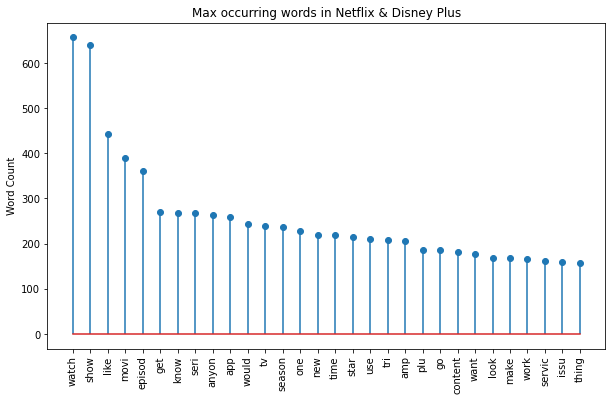

In [73]:
plot_stembar(netflix_disneyplus_wordcount.head(30), 'Max occurring words in Netflix & Disney Plus')

As both the subreddits are of the same category of streaming tv shows and movies, they have alot of general words in common like watch, show, movi, episode, season, etc. This shows that the reddit users are mostly talking about the shows and movies aired in the respective service. <br>
We will get a better understanding of other topics that they are discussing later on while modelling.

Word cloud for combined data:

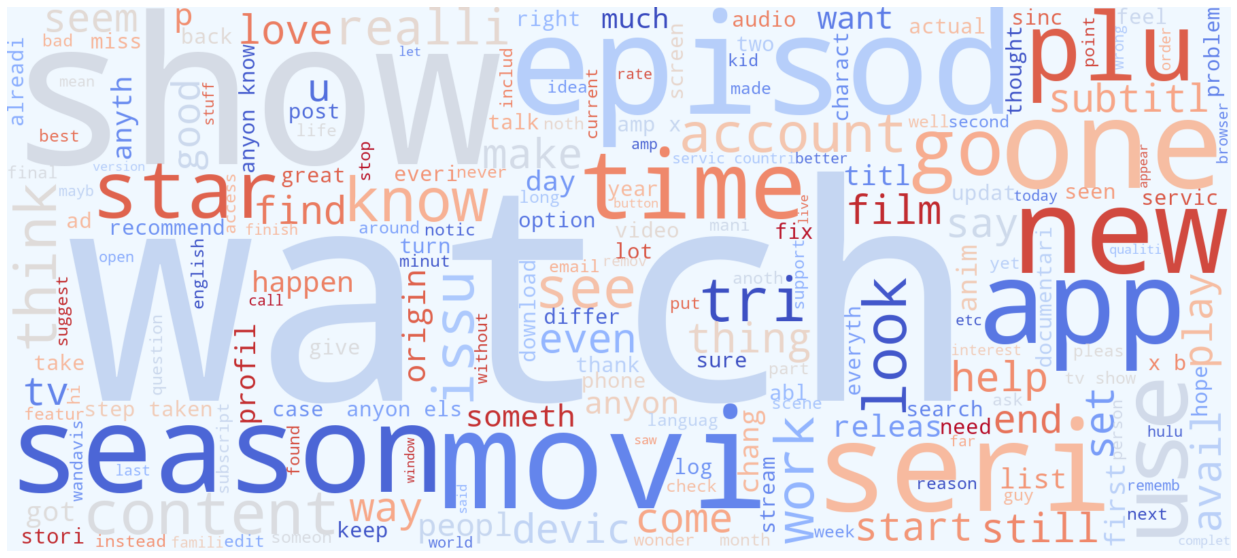

In [75]:
 plot_wordcloud(netflix_disneyplus['cleaned_text'], 'aliceblue', 'coolwarm')   